# Toy UKF + Causal Window Transformer NoiseNet (Full Cholesky Qx/R + pₖ→Qθ Gating)

This notebook implements a **minimal end-to-end toy** for your setup:

- **2-DOF** dynamics with state \(x=[q_1,q_2,v_1,v_2]\) (nx=4) and measurement \(y=[q_1,q_2]\) (ny=2)  
- **Augmented state** \(z=[x;\theta]\) with a **single parameter** \(\theta\) scaling stiffness  
- Sequence length **T=2000**, random change-point \(k^*\), and **+30% step jump** in \(\theta\)  
- A **causal Transformer** predicts **full SPD** \(Q_{x,k}\) and \(R_k\) via **Cholesky factors**, plus a change logit \(p_k\)  
- \(p_k\) gates \(Q_{\theta,k}\) inside the UKF predict covariance:
  \[
  Q_{\theta,k}=(1-\sigma(p_k))Q_{\theta}^{\text{base}}+\sigma(p_k)Q_{\theta}^{\text{jump}}
  \]
- Training uses **sliding windows** with **burn-in**, **state supervision**, and **BCE supervision** for change detection.

> Tip: Start with the default small training settings to sanity-check. Then increase epochs/steps to improve adaptation speed.


In [10]:

# --- Setup ---
from __future__ import annotations
import math, random
from dataclasses import dataclass
from typing import Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os


print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.10.0+cu128
cuda available: True


In [ ]:

# --- Config ---
@dataclass
class CFG:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: torch.dtype = torch.float32

    # problem dims
    nx: int = 4
    ny: int = 2
    nt: int = 1
    nz: int = 5

    # simulation
    dt: float = 0.02
    T: int = 2000
    jump_ratio: float = 0.30
    kstar_lo: float = 0.3
    kstar_hi: float = 0.7

    # UKF params
    alpha: float = 1.0
    beta: float = 2.0
    kappa: float = 0.0
    jitter_P: float = 1e-3
    jitter_S: float = 1e-6

    # NoiseNet / Transformer
    W: int = 128              # sliding window length for features (past-only)
    d_model: int = 128
    n_layers: int = 2
    n_heads: int = 4
    dropout: float = 0.1

    # Training windows (burn-in + loss)
    burn_in: int = 128
    L: int = 256

    # Dataset sizes
    batch_size: int = 32

    n_train_seq: int = 128*2
    n_val_seq: int = 32*2
    n_test_seq: int = 32*2

    # Training (keep small for sanity-check; increase later)
    lr: float = 3e-4
    epochs: int = 3
    steps_per_epoch: int = 100

    # Loss weights
    w_state: float = 1.0
    w_bce: float = 0.2
    w_smooth: float = 1e-4
    w_offdiag: float = 1e-4

    # Q_theta gating (variance)
    Qtheta_base: float = 1e-8
    Qtheta_jump: float = 1e-4   # increase (e.g., 1e-3) for faster adaptation if stable

    # label width after change (p_k uses features up to k-1, so label starts at k*+1)
    p_label_width: int = 25

cfg = CFG()
print(cfg)


CFG(device='cuda', dtype=torch.float32, nx=4, ny=2, nt=1, nz=5, dt=0.02, T=2000, jump_ratio=0.3, kstar_lo=0.3, kstar_hi=0.7, alpha=1.0, beta=2.0, kappa=0.0, jitter_P=0.001, jitter_S=1e-06, W=128, d_model=128, n_layers=2, n_heads=4, dropout=0.1, burn_in=128, L=256, batch_size=16, n_train_seq=256, n_val_seq=64, n_test_seq=64, lr=0.0003, epochs=3, steps_per_epoch=100, w_state=1.0, w_bce=0.2, w_smooth=0.0001, w_offdiag=0.0001, Qtheta_base=1e-08, Qtheta_jump=0.0001, p_label_width=25)


In [3]:

# --- Utilities: Cholesky parameterization for full SPD Qx and R ---

def n_tril(n: int) -> int:
    return n * (n + 1) // 2


def vec_to_cholesky(v: torch.Tensor, n: int, eps: float = 1e-4,
                    diag_min: float = -12.0, diag_max: float = 6.0,
                    off_clip: float = 3.0) -> torch.Tensor:
    """
    v: (..., n_tril(n)) lower-triangular params
       convention: first n entries -> diag logits, remaining -> strict-lower row-wise
    returns L: (..., n, n) with positive diag (via softplus)

    Safety:
      - nan/inf -> 0
      - diag logits clamped to [diag_min, diag_max]
      - off-diagonals clipped to [-off_clip, off_clip]
    """
    v = torch.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    diag_logits = torch.clamp(v[..., :n], min=diag_min, max=diag_max)
    off = torch.clamp(v[..., n:], min=-off_clip, max=off_clip)

    L = v.new_zeros(*v.shape[:-1], n, n)
    diag = F.softplus(diag_logits) + eps
    idx = torch.arange(n, device=v.device)
    L[..., idx, idx] = diag

    k = 0
    for i in range(1, n):
        for j in range(i):
            L[..., i, j] = off[..., k]
            k += 1
    return L


def chol_to_spd(L: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    n = L.shape[-1]
    I = torch.eye(n, device=L.device, dtype=L.dtype)
    return L @ L.transpose(-1, -2) + eps * I

def blockdiag(Qx: torch.Tensor, Qt: torch.Tensor) -> torch.Tensor:
    """
    Qx: (B,nx,nx), Qt: (B,nt,nt) -> Qz: (B,nz,nz)
    """
    B, nx, _ = Qx.shape
    _, nt, _ = Qt.shape
    Qz = Qx.new_zeros(B, nx + nt, nx + nt)
    Qz[:, :nx, :nx] = Qx
    Qz[:, nx:, nx:] = Qt
    return Qz


In [4]:

# --- Physics: 2-DOF model (theta scales the coupling stiffness) ---

def build_mck(theta: torch.Tensor, device, dtype) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    theta: (B,1) stiffness scale for coupling spring
    Returns M,C,K for each batch as (B,2,2)
    """
    B = theta.shape[0]
    m1, m2 = 1.0, 1.0
    c1, c2, cc = 0.05, 0.05, 0.02
    k1, k2 = 20.0, 20.0
    kc0 = 15.0
    kc = kc0 * theta.squeeze(-1)  # (B,)

    M = torch.tensor([[m1, 0.0],[0.0, m2]], device=device, dtype=dtype).expand(B,2,2).clone()

    # Damping: C = [[c1+cc, -cc],[-cc, c2+cc]]
    C = torch.zeros(B,2,2, device=device, dtype=dtype)
    C[:,0,0] = c1 + cc
    C[:,1,1] = c2 + cc
    C[:,0,1] = -cc
    C[:,1,0] = -cc

    # Stiffness: K = [[k1+kc, -kc],[-kc, k2+kc]]
    K = torch.zeros(B,2,2, device=device, dtype=dtype)
    K[:,0,0] = k1 + kc
    K[:,1,1] = k2 + kc
    K[:,0,1] = -kc
    K[:,1,0] = -kc
    return M, C, K

def f_step(z: torch.Tensor, dt: float) -> torch.Tensor:
    """
    z: (B, nz) = [q1,q2,v1,v2,theta]
    deterministic transition (no noise added here)
    """
    device, dtype = z.device, z.dtype
    q = z[:, 0:2]            # (B,2)
    v = z[:, 2:4]            # (B,2)
    theta = z[:, 4:5]        # (B,1)

    M, C, K = build_mck(theta, device, dtype)
    Minv = torch.linalg.inv(M)

    a = -(Minv @ (C @ v.unsqueeze(-1) + K @ q.unsqueeze(-1))).squeeze(-1)  # (B,2)

    q_next = q + dt * v
    v_next = v + dt * a
    theta_next = theta  # random-walk handled via Q_theta in the filter

    return torch.cat([q_next, v_next, theta_next], dim=-1)

def h_meas(z: torch.Tensor) -> torch.Tensor:
    # measurement: y = [q1,q2]
    return z[:, 0:2]


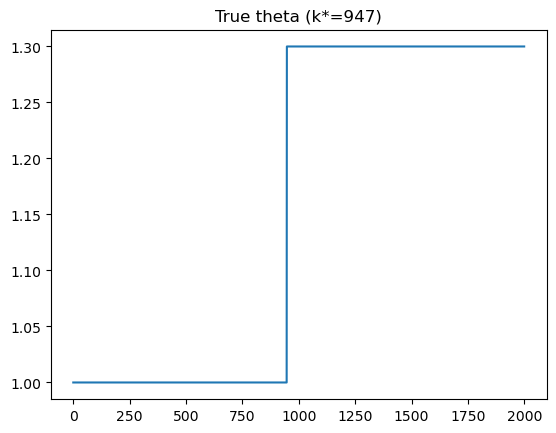

In [5]:

# --- Simulation: T=2000 with random k* and +30% step jump in theta ---

@torch.no_grad()
def simulate_sequence(T: int, dt: float, jump_ratio: float, kstar: int, device, dtype):
    """
    Generates x_true (T,nx), theta_true (T,1), y (T,ny)
    """
    theta0 = 1.0
    theta1 = theta0 * (1.0 + jump_ratio)  # +30% at/after k*
    theta_true = torch.full((T,1), theta0, device=device, dtype=dtype)
    theta_true[kstar:, 0] = theta1

    # initial state
    q0 = torch.tensor([0.2, -0.1], device=device, dtype=dtype)
    v0 = torch.tensor([0.0, 0.0], device=device, dtype=dtype)
    x = torch.cat([q0, v0]).unsqueeze(0)  # (1,4)

    # simulation noises
    Qsim = torch.diag(torch.tensor([1e-6,1e-6,1e-5,1e-5], device=device, dtype=dtype))
    Lsim = torch.linalg.cholesky(Qsim)

    Rsim = torch.diag(torch.tensor([2e-4, 2e-4], device=device, dtype=dtype))
    Lr = torch.linalg.cholesky(Rsim)

    x_true = torch.zeros(T,4, device=device, dtype=dtype)
    y = torch.zeros(T,2, device=device, dtype=dtype)

    for k in range(T):
        th = theta_true[k:k+1]  # (1,1)
        z = torch.cat([x, th], dim=-1)  # (1,5)

        z_next = f_step(z, dt=dt)
        x_next = z_next[:, :4]
        x_next = x_next + (torch.randn(1,4, device=device, dtype=dtype) @ Lsim.T)
        x = x_next

        x_true[k] = x.squeeze(0)
        y[k] = x_true[k, :2] + (torch.randn(2, device=device, dtype=dtype) @ Lr.T)

    return x_true, theta_true, y

def make_p_label(T: int, kstar: int, width: int, device, dtype):
    # label starts at kstar+1 because p_k is predicted from phi up to k-1
    start = min(T-1, kstar + 1)
    end = min(T, start + width)
    p = torch.zeros(T,1, device=device, dtype=dtype)
    p[start:end, 0] = 1.0
    return p

# quick sanity-check visualization of one simulated sequence
device, dtype = cfg.device, cfg.dtype
kstar = random.randint(int(cfg.kstar_lo*cfg.T), int(cfg.kstar_hi*cfg.T))
x_true, theta_true, y = simulate_sequence(cfg.T, cfg.dt, cfg.jump_ratio, kstar, device, dtype)

plt.figure()
plt.plot(theta_true.cpu().numpy())
plt.title(f"True theta (k*={kstar})")
plt.show()


In [6]:

def safe_cholesky(A: torch.Tensor, jitter: float = 1e-6, max_tries: int = 8) -> torch.Tensor:
    """
    Robust Cholesky with increasing diagonal loading + nan/inf sanitization.
    """
    A = torch.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)
    A = 0.5 * (A + A.transpose(-1,-2))
    n = A.shape[-1]
    I = torch.eye(n, device=A.device, dtype=A.dtype).unsqueeze(0)
    for i in range(max_tries):
        try:
            return torch.linalg.cholesky(A + (jitter * (10.0**i)) * I)
        except Exception:
            continue
    # fallback: eigen projection
    w, V = torch.linalg.eigh(A)
    w = torch.clamp(w, min=jitter)
    A_spd = V @ torch.diag_embed(w) @ V.transpose(-1,-2)
    return torch.linalg.cholesky(A_spd + jitter*I)



# --- Innovation features phi_k = [L^{-1}e, |L^{-1}e|, NIS, logdetS] ---

def make_phi(e: torch.Tensor, S: torch.Tensor, jitter: float = 1e-6) -> torch.Tensor:
    """
    e: (B,ny)
    S: (B,ny,ny) SPD
    returns phi: (B, d_in) = [e_white, |e_white|, nis, logdetS]
    """
    B, ny = e.shape
    I = torch.eye(ny, device=e.device, dtype=e.dtype).unsqueeze(0)
    S = S + jitter * I
    L = safe_cholesky(S, jitter=jitter)  # (B,ny,ny)
    # e_white = L^{-1} e
    e_white = torch.linalg.solve_triangular(L, e.unsqueeze(-1), upper=False).squeeze(-1)
    nis = (e_white**2).sum(dim=-1, keepdim=True)
    logdetS = 2.0 * torch.log(torch.diagonal(L, dim1=-2, dim2=-1)).sum(dim=-1, keepdim=True)
    phi = torch.cat([e_white, e_white.abs(), nis, logdetS], dim=-1)
    return phi


In [7]:

def sanitize_sym(A: torch.Tensor) -> torch.Tensor:
    A = torch.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)
    return 0.5 * (A + A.transpose(-1,-2))

def make_spd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Project a symmetric matrix to SPD by clamping eigenvalues.
    """
    A = sanitize_sym(A)
    w, V = torch.linalg.eigh(A)
    w = torch.clamp(w, min=eps)
    A_spd = V @ torch.diag_embed(w) @ V.transpose(-1,-2)
    n = A.shape[-1]
    I = torch.eye(n, device=A.device, dtype=A.dtype)
    return A_spd + eps * I


def sqrtm_spd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Symmetric matrix square root for (approx) SPD matrices using eigendecomposition.
    Returns U such that U U^T ≈ A. Works even when Cholesky fails.
    """
    A = sanitize_sym(A)
    w, V = torch.linalg.eigh(A)
    w = torch.clamp(w, min=eps)
    return V @ torch.diag_embed(torch.sqrt(w))


def safe_cholesky(A: torch.Tensor, jitter: float = 1e-6, max_tries: int = 8) -> torch.Tensor:
    A = sanitize_sym(A)
    n = A.shape[-1]
    I = torch.eye(n, device=A.device, dtype=A.dtype).unsqueeze(0)
    for i in range(max_tries):
        try:
            return torch.linalg.cholesky(A + (jitter * (10.0**i)) * I)
        except Exception:
            continue
    # fallback: eigen projection then cholesky
    A = make_spd(A, eps=jitter)
    return torch.linalg.cholesky(A + jitter * I)



def make_spd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Project a symmetric matrix to SPD by clamping eigenvalues.
    A: (B,n,n)
    """
    A = 0.5 * (A + A.transpose(-1, -2))
    w, V = torch.linalg.eigh(A)
    w = torch.clamp(w, min=eps)
    return V @ torch.diag_embed(w) @ V.transpose(-1, -2)



# --- UKF step (batched) ---

def ukf_step(z: torch.Tensor, P: torch.Tensor, y: torch.Tensor, Qz: torch.Tensor, R: torch.Tensor,
            dt: float, alpha: float, beta: float, kappa: float,
            jitter_P: float, jitter_S: float):
    """
    z: (B,nz) mean
    P: (B,nz,nz)
    y: (B,ny)
    Qz: (B,nz,nz)
    R:  (B,ny,ny)
    Returns z_upd, P_upd, innovation e, S
    """
    device, dtype = z.device, z.dtype
    B, nz = z.shape
    ny = y.shape[-1]

    lam = alpha**2 * (nz + kappa) - nz
    c = nz + lam
    Wm0 = lam / c
    Wc0 = Wm0 + (1 - alpha**2 + beta)
    W = 1.0 / (2.0 * c)

    # cholesky of P
    I = torch.eye(nz, device=device, dtype=dtype).unsqueeze(0)
    Pj = make_spd(P, eps=jitter_P)
    U = sqrtm_spd(Pj, eps=jitter_P)  # robust matrix sqrt (no Cholesky)
    U = U * math.sqrt(c)

    # sigma points
    sigmas = z.unsqueeze(1).repeat(1, 2*nz+1, 1)
    Ucols = U.transpose(-1, -2)  # each row = a column of U
    sigmas[:, 1:nz+1, :] = z.unsqueeze(1) + Ucols
    sigmas[:, nz+1:,  :] = z.unsqueeze(1) - Ucols

    # propagate through dynamics
    sig_flat = sigmas.reshape(B*(2*nz+1), nz)
    zprop = f_step(sig_flat, dt=dt).reshape(B, 2*nz+1, nz)

    # weights
    wm = torch.full((2*nz+1,), W, device=device, dtype=dtype)
    wc = torch.full((2*nz+1,), W, device=device, dtype=dtype)
    wm[0] = Wm0
    wc[0] = Wc0

    # predicted mean/cov
    z_pred = (zprop * wm.view(1,-1,1)).sum(dim=1)
    dz = zprop - z_pred.unsqueeze(1)
    P_pred = torch.einsum("i,bij,bik->bjk", wc, dz, dz) + Qz

    # predicted measurement
    yprop = h_meas(zprop.reshape(B*(2*nz+1), nz)).reshape(B, 2*nz+1, ny)
    y_pred = (yprop * wm.view(1,-1,1)).sum(dim=1)
    dy = yprop - y_pred.unsqueeze(1)
    S = torch.einsum("i,bij,bik->bjk", wc, dy, dy) + R
    Pzy = torch.einsum("i,bij,bik->bjk", wc, dz, dy)

    # stabilize S
    I_y = torch.eye(ny, device=device, dtype=dtype).unsqueeze(0)
    S = S + jitter_S * I_y
    S = make_spd(S, eps=jitter_S)

    # gain and update
    Ls = safe_cholesky(S, jitter=jitter_S)
    # K = Pzy @ S^{-1} using Cholesky solves
    tmp = torch.linalg.solve_triangular(Ls, Pzy.transpose(-1,-2), upper=False)
    tmp = torch.linalg.solve_triangular(Ls.transpose(-1,-2), tmp, upper=True)
    K = tmp.transpose(-1,-2)
    e = y - y_pred
    z_upd = z_pred + torch.einsum("bij,bj->bi", K, e)
    P_upd = P_pred - K @ S @ K.transpose(-1,-2)
    P_upd = 0.5 * (P_upd + P_upd.transpose(-1,-2))
    P_upd = make_spd(P_upd, eps=jitter_P)
    return z_upd, P_upd, e, S


In [8]:

# --- Causal window Transformer NoiseNet ---
# It predicts Qx_k, R_k (full SPD via Cholesky factors) and a change logit p_k.
# It only sees past features (phi up to k-1), so the whole pipeline is causal.

class CausalWindowTransformerNoiseNet(nn.Module):
    def __init__(self, d_in: int, d_model: int, nx: int, ny: int,
                 W: int, n_layers: int, n_heads: int, dropout: float):
        super().__init__()
        self.nx, self.ny = nx, ny
        self.nQ = n_tril(nx)
        self.nR = n_tril(ny)
        self.d_out = self.nQ + self.nR + 1

        self.in_proj = nn.Linear(d_in, d_model)
        self.pos = nn.Parameter(torch.zeros(1, W, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Linear(d_model, self.d_out)

        # initialize to small-ish Q/R (stability)
        with torch.no_grad():
            self.head.weight.mul_(0.01)
            self.head.bias.zero_()
            self.head.bias[:nx] = -6.0               # Q diag logits
            self.head.bias[self.nQ:self.nQ+ny] = -6.0 # R diag logits

    def forward(self, phi_seq: torch.Tensor):
        # phi_seq: (B,W,d_in)
        B, W, _ = phi_seq.shape
        h = self.in_proj(phi_seq) + self.pos[:, :W, :]
        h = self.enc(h)
        out = self.head(h[:, -1, :])  # last token as "current" prediction

        qv = out[:, :self.nQ]
        rv = out[:, self.nQ:self.nQ+self.nR]
        p_logit = out[:, -1:]
        return qv, rv, p_logit


In [11]:

# --- Dataset creation (in-memory): random k* per sequence ---
# --- 데이터 저장 경로 설정 ---
DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)

TRAIN_FILE = os.path.join(DATA_DIR, "train_data.pt")
VAL_FILE = os.path.join(DATA_DIR, "val_data.pt")
TEST_FILE = os.path.join(DATA_DIR, "test_data.pt")

@torch.no_grad()
def build_dataset(n_seq: int, cfg: CFG):
    dev, dt = cfg.device, cfg.dtype
    data = []
    for _ in range(n_seq):
        kstar = random.randint(int(cfg.kstar_lo * cfg.T), int(cfg.kstar_hi * cfg.T))
        x_true, theta_true, y = simulate_sequence(cfg.T, cfg.dt, cfg.jump_ratio, kstar, dev, dt)
        p = make_p_label(cfg.T, kstar, cfg.p_label_width, dev, dt)
        data.append({"x_true": x_true, "theta_true": theta_true, "y": y, "p": p, "kstar": kstar})
    return data

def sample_batch(data, cfg: CFG):
    B = cfg.batch_size
    T = cfg.T
    seg = cfg.burn_in + cfg.L
    idx = random.sample(range(len(data)), B)
    s_max = T - seg - 1
    starts = [random.randint(0, s_max) for _ in range(B)]

    y = []
    x = []
    p = []
    for i, s in zip(idx, starts):
        d = data[i]
        y.append(d["y"][s:s+seg])
        x.append(d["x_true"][s:s+seg])
        p.append(d["p"][s:s+seg])

    return torch.stack(y, 0), torch.stack(x, 0), torch.stack(p, 0)

def prepare_datasets(cfg, force_generate=False):
    """
    데이터 파일이 있으면 로드하고, 없으면 생성 후 저장합니다.
    force_generate=True로 설정하면 무조건 새로 생성하고 덮어씁니다.
    """
    # 1. 파일이 모두 존재하고, 강제 생성이 아닐 경우 -> 로드
    if os.path.exists(TRAIN_FILE) and os.path.exists(VAL_FILE) and os.path.exists(TEST_FILE) and not force_generate:
        print(f"Loading datasets from {DATA_DIR}...")
        train_data = torch.load(TRAIN_FILE)
        val_data = torch.load(VAL_FILE)
        test_data = torch.load(TEST_FILE)
        print("Data loaded successfully.")
    
    # 2. 파일이 없거나 강제 생성일 경우 -> 생성 및 저장
    else:
        print("Generating new datasets...")
        # (1) Training Data
        print(f"  - Building Train ({cfg.n_train_seq} seq)...")
        train_data = build_dataset(cfg.n_train_seq, cfg)
        
        # (2) Validation Data
        print(f"  - Building Val ({cfg.n_val_seq} seq)...")
        val_data = build_dataset(cfg.n_val_seq, cfg)
        
        # (3) Testing Data (새로 추가됨)
        print(f"  - Building Test ({cfg.n_test_seq} seq)...")
        test_data = build_dataset(cfg.n_test_seq, cfg)
        
        # 저장
        print(f"Saving datasets to {DATA_DIR}...")
        torch.save(train_data, TRAIN_FILE)
        torch.save(val_data, VAL_FILE)
        torch.save(test_data, TEST_FILE)
        print("Data generation and saving complete.")
        
    return train_data, val_data, test_data

# --- 실행 ---
# force_generate=True로 하면 기존 파일을 무시하고 새로 만듭니다.
train_data, val_data, test_data = prepare_datasets(cfg, force_generate=False)

print(f"Dataset Sizes -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")




Loading datasets from ./data...
Data loaded successfully.
Dataset Sizes -> Train: 256, Val: 64, Test: 64


In [12]:

# --- Differentiable rollout on one (burn-in + loss) window ---

def rollout_window(net: nn.Module, y_seg: torch.Tensor, x_true_seg: torch.Tensor, p_label_seg: torch.Tensor, cfg: CFG):
    """
    y_seg: (B,Tseg,ny), x_true_seg: (B,Tseg,nx), p_label_seg: (B,Tseg,1)
    Returns dict(losses, trajectories)
    """
    device, dtype = y_seg.device, y_seg.dtype
    B, Tseg, ny = y_seg.shape
    nx, nz = cfg.nx, cfg.nz

    d_in = 2*ny + 2

    # init z and P
    q0 = y_seg[:, 0, :]
    v0 = torch.zeros(B,2, device=device, dtype=dtype)
    theta0 = torch.ones(B,1, device=device, dtype=dtype)
    z = torch.cat([q0, v0, theta0], dim=-1)

    P = torch.diag(torch.tensor([1e-2,1e-2, 1e-1,1e-1, 1e-2], device=device, dtype=dtype)).unsqueeze(0).repeat(B,1,1)

    # feature buffer: past-only features
    phi_buf = torch.zeros(B, cfg.W, d_in, device=device, dtype=dtype)

    xhat, thetahat, ppred = [], [], []
    qv_hist, rv_hist = [], []

    for t in range(Tseg):
        # 1) predict Qx_k, R_k, p_k from past feature window
        qv, rv, p_logit = net(phi_buf)
        p = torch.sigmoid(p_logit)

        # 2) build full SPD Qx and R via Cholesky
        Lq = vec_to_cholesky(qv, nx)
        Qx = chol_to_spd(Lq)
        Lr = vec_to_cholesky(rv, ny)
        R = chol_to_spd(Lr)

        # 3) gate Q_theta,k using p_k (THIS is the key location)
        qtheta = (1.0 - p) * cfg.Qtheta_base + p * cfg.Qtheta_jump
        Qt = qtheta.view(B,1,1)
        Qz = blockdiag(Qx, Qt)

        # 4) UKF update
        z, P, e, S = ukf_step(
            z, P, y_seg[:, t, :], Qz, R,
            dt=cfg.dt, alpha=cfg.alpha, beta=cfg.beta, kappa=cfg.kappa,
            jitter_P=cfg.jitter_P, jitter_S=cfg.jitter_S
        )

        # 5) create phi_t and append to buffer (for next step)
        phi_t = make_phi(e, S, jitter=cfg.jitter_S)
        phi_buf = torch.cat([phi_buf[:, 1:, :], phi_t.unsqueeze(1)], dim=1)

        xhat.append(z[:, :nx])
        thetahat.append(z[:, nx:nx+1])
        ppred.append(p_logit)
        qv_hist.append(qv)
        rv_hist.append(rv)

    xhat = torch.stack(xhat, 1)
    thetahat = torch.stack(thetahat, 1)
    ppred = torch.stack(ppred, 1)
    qv_hist = torch.stack(qv_hist, 1)
    rv_hist = torch.stack(rv_hist, 1)

    start = cfg.burn_in
    end = cfg.burn_in + cfg.L

    x_loss = F.mse_loss(xhat[:, start:end, :], x_true_seg[:, start:end, :])
    bce = F.binary_cross_entropy_with_logits(ppred[:, start:end, :], p_label_seg[:, start:end, :])

    dq = (qv_hist[:, start+1:end, :] - qv_hist[:, start:end-1, :]).pow(2).mean()
    dr = (rv_hist[:, start+1:end, :] - rv_hist[:, start:end-1, :]).pow(2).mean()
    smooth = dq + dr

    q_off = qv_hist[:, start:end, nx:]
    r_off = rv_hist[:, start:end, ny:]
    offdiag = (q_off.pow(2).mean() + r_off.pow(2).mean())

    loss = cfg.w_state*x_loss + cfg.w_bce*bce + cfg.w_smooth*smooth + cfg.w_offdiag*offdiag

    return {
        "loss": loss,
        "x_loss": x_loss.detach(),
        "bce": bce.detach(),
        "smooth": smooth.detach(),
        "offdiag": offdiag.detach(),
        "xhat": xhat.detach(),
        "thetahat": thetahat.detach(),
        "ppred": ppred.detach(),
    }


In [13]:

# --- Train ---

torch.manual_seed(0)
random.seed(0)

d_in = 2*cfg.ny + 2
net = CausalWindowTransformerNoiseNet(
    d_in=d_in, d_model=cfg.d_model, nx=cfg.nx, ny=cfg.ny,
    W=cfg.W, n_layers=cfg.n_layers, n_heads=cfg.n_heads, dropout=cfg.dropout
).to(cfg.device)

opt = torch.optim.AdamW(net.parameters(), lr=cfg.lr, weight_decay=1e-4)

for ep in range(cfg.epochs):
    net.train()
    loss_sum = x_sum = bce_sum = 0.0

    for it in range(cfg.steps_per_epoch):
        y_seg, x_seg, p_seg = sample_batch(train_data, cfg)
        out = rollout_window(net, y_seg, x_seg, p_seg, cfg)

        opt.zero_grad(set_to_none=True)
        out["loss"].backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()

        loss_sum += float(out["loss"].detach())
        x_sum += float(out["x_loss"])
        bce_sum += float(out["bce"])

    net.eval()
    with torch.no_grad():
        yv, xv, pv = sample_batch(val_data, cfg)
        outv = rollout_window(net, yv, xv, pv, cfg)

    print(f"[ep {ep+1}/{cfg.epochs}] "
          f"train loss {loss_sum/cfg.steps_per_epoch:.4f} (x {x_sum/cfg.steps_per_epoch:.4f}, bce {bce_sum/cfg.steps_per_epoch:.4f}) | "
          f"val loss {float(outv['loss']):.4f} (x {float(outv['x_loss']):.4f}, bce {float(outv['bce']):.4f})")


C:\Users\minhy\AppData\Local\Temp\ipykernel_11812\4182933182.py:21: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)


_LinAlgError: linalg.cholesky: (Batch element 1): The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).

In [ ]:

# --- Full 2000-step rollout + plots around k* ---

@torch.no_grad()
def rollout_full(net: nn.Module, y: torch.Tensor, cfg: CFG):
    """
    y: (T,ny)
    returns xhat (T,nx), thetahat (T,1), p (T,1)
    """
    device, dtype = cfg.device, cfg.dtype
    ny, nx = cfg.ny, cfg.nx
    d_in = 2*ny + 2

    q0 = y[0:1, :]
    v0 = torch.zeros(1,2, device=device, dtype=dtype)
    theta0 = torch.ones(1,1, device=device, dtype=dtype)
    z = torch.cat([q0, v0, theta0], dim=-1)

    P = torch.diag(torch.tensor([1e-2,1e-2, 1e-1,1e-1, 1e-2], device=device, dtype=dtype)).unsqueeze(0)
    phi_buf = torch.zeros(1, cfg.W, d_in, device=device, dtype=dtype)

    xhat = torch.zeros(cfg.T, nx, device=device, dtype=dtype)
    thetahat = torch.zeros(cfg.T, 1, device=device, dtype=dtype)
    p = torch.zeros(cfg.T, 1, device=device, dtype=dtype)

    for t in range(cfg.T):
        qv, rv, p_logit = net(phi_buf)
        p_t = torch.sigmoid(p_logit)

        Lq = vec_to_cholesky(qv, nx)
        Qx = chol_to_spd(Lq)
        Lr = vec_to_cholesky(rv, ny)
        R = chol_to_spd(Lr)

        qtheta = (1.0 - p_t) * cfg.Qtheta_base + p_t * cfg.Qtheta_jump
        Qt = qtheta.view(1,1,1)
        Qz = blockdiag(Qx, Qt)

        z, P, e, S = ukf_step(
            z, P, y[t:t+1, :], Qz, R,
            dt=cfg.dt, alpha=cfg.alpha, beta=cfg.beta, kappa=cfg.kappa,
            jitter_P=cfg.jitter_P, jitter_S=cfg.jitter_S
        )

        phi_t = make_phi(e, S, jitter=cfg.jitter_S)
        phi_buf = torch.cat([phi_buf[:, 1:, :], phi_t.unsqueeze(1)], dim=1)

        xhat[t] = z[0, :nx]
        thetahat[t] = z[0, nx:nx+1]
        p[t] = p_t[0]

    return xhat, thetahat, p

# pick one validation sequence
d = random.choice(val_data)
kstar = d["kstar"]
y = d["y"]
theta_true = d["theta_true"]

xhat, thetahat, p = rollout_full(net, y, cfg)

# compute "adaptation time" to be within 5% of new theta
theta_new = theta_true[kstar, 0].item()
tol = 0.05 * theta_new
err = (thetahat[:,0] - theta_true[:,0]).abs()
after = err[kstar:]
idx = (after < tol).nonzero(as_tuple=False)
t_adapt = int(idx[0].item()) if idx.numel() > 0 else None

print("k* =", kstar)
print("theta_new =", theta_new, "| tol(5%) =", tol)
print("first time within tol after k*:", t_adapt, "steps (target <= 100)")

# plot theta and p around k*
w = 250
a = max(0, kstar - w)
b = min(cfg.T, kstar + w)

plt.figure()
plt.plot(theta_true[a:b,0].cpu().numpy(), label="theta true")
plt.plot(thetahat[a:b,0].cpu().numpy(), label="theta hat")
plt.axvline(x=kstar-a)
plt.title("Theta jump and estimate (zoomed)")
plt.legend()
plt.show()

plt.figure()
plt.plot(p[a:b,0].cpu().numpy())
plt.axvline(x=kstar-a)
plt.title("p_k (change probability) (zoomed)")
plt.show()
